In [1]:
!pip install -q plotly scikit-learn pandas numpy matplotlib seaborn openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


 All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

print(" Downloading dataset... (this may take 1-2 minutes)")
try:
    df = pd.read_excel(url)
    print(" Dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f" Error loading dataset: {e}")
    print("Alternative: Upload the file manually to Colab")

# Display first few rows
print("\n First 5 rows of the dataset:")
df.head()


 Dataset loaded successfully!
Dataset shape: (541909, 8)

 First 5 rows of the dataset:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Basic information
print("\n1️ Dataset Information:")
print(f"   - Total records: {len(df):,}")
print(f"   - Total columns: {len(df.columns)}")
print(f"   - Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")

# Check data types
print("\n2️ Column Data Types:")
print(df.dtypes)

# Check missing values
print("\n3️ Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

# Statistical summary
print("\n4️ Statistical Summary:")
df.describe()


EXPLORATORY DATA ANALYSIS

1️ Dataset Information:
   - Total records: 541,909
   - Total columns: 8
   - Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00

2️ Column Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

3️ Missing Values:
             Missing Count  Percentage
Description           1454    0.268311
CustomerID          135080   24.926694

4️ Statistical Summary:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
print("="*50)
print("DATA CLEANING")
print("="*50)
df_clean = df.copy()

print(f"Original dataset size: {len(df_clean):,} rows")
# 1. Remove rows with missing CustomerID
df_clean = df_clean.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerID: {len(df_clean):,} rows")

# 2. Remove rows with missing Description
df_clean = df_clean.dropna(subset=['Description'])
print(f"After removing missing Description: {len(df_clean):,} rows")

# 3. Remove cancelled orders (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancelled orders: {len(df_clean):,} rows")

# 4. Remove negative quantities and prices
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"After removing negative values: {len(df_clean):,} rows")

# 5. Create TotalPrice column
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 6. Convert CustomerID to integer
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

print("\n Data cleaning completed!")
print(f"Final clean dataset: {len(df_clean):,} rows")

# Show cleaned data
df_clean.head()

DATA CLEANING
Original dataset size: 541,909 rows
After removing missing CustomerID: 406,829 rows
After removing missing Description: 406,829 rows
After removing cancelled orders: 397,924 rows
After removing negative values: 397,884 rows

 Data cleaning completed!
Final clean dataset: 397,884 rows


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [6]:
print("="*50)
print("FEATURE ENGINEERING - RFM ANALYSIS")
print("="*50)

# Get the latest date in the dataset (for recency calculation)
latest_date = df_clean['InvoiceDate'].max()
print(f"Latest transaction date: {latest_date}")

# Calculate RFM metrics for each customer
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\n RFM Metrics Calculated:")
print(f"Total customers: {len(rfm):,}")
print("\nFirst 5 customers:")
print(rfm.head())

print("\n RFM Statistics:")
print(rfm.describe())

# Additional features
print("\n Creating additional features...")

# Average order value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Total items purchased
items_per_customer = df_clean.groupby('CustomerID')['Quantity'].sum().reset_index()
items_per_customer.columns = ['CustomerID', 'TotalItems']
rfm = rfm.merge(items_per_customer, on='CustomerID')

# Unique products purchased
unique_products = df_clean.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products.columns = ['CustomerID', 'UniqueProducts']
rfm = rfm.merge(unique_products, on='CustomerID')

print(" Additional features created!")
print("\nFinal feature set:")
print(rfm.head())



FEATURE ENGINEERING - RFM ANALYSIS
Latest transaction date: 2011-12-09 12:50:00

 RFM Metrics Calculated:
Total customers: 4,338

First 5 customers:
   CustomerID  Recency  Frequency  Monetary
0       12346      325          1  77183.60
1       12347        1          7   4310.00
2       12348       74          4   1797.24
3       12349       18          1   1757.55
4       12350      309          1    334.40

 RFM Statistics:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    91.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     0.000000     1.000000       3.750000
25%    13813.250000    17.000000     1.000000     307.415000
50%    15299.500000    50.000000     2.000000     674.485000
75%    16778.750000   141.000000     5.000000    1661.740000
max    18287.000000   373.000000   209.000000  280206.020000

 Creating additiona

DATA VISUALIZATION


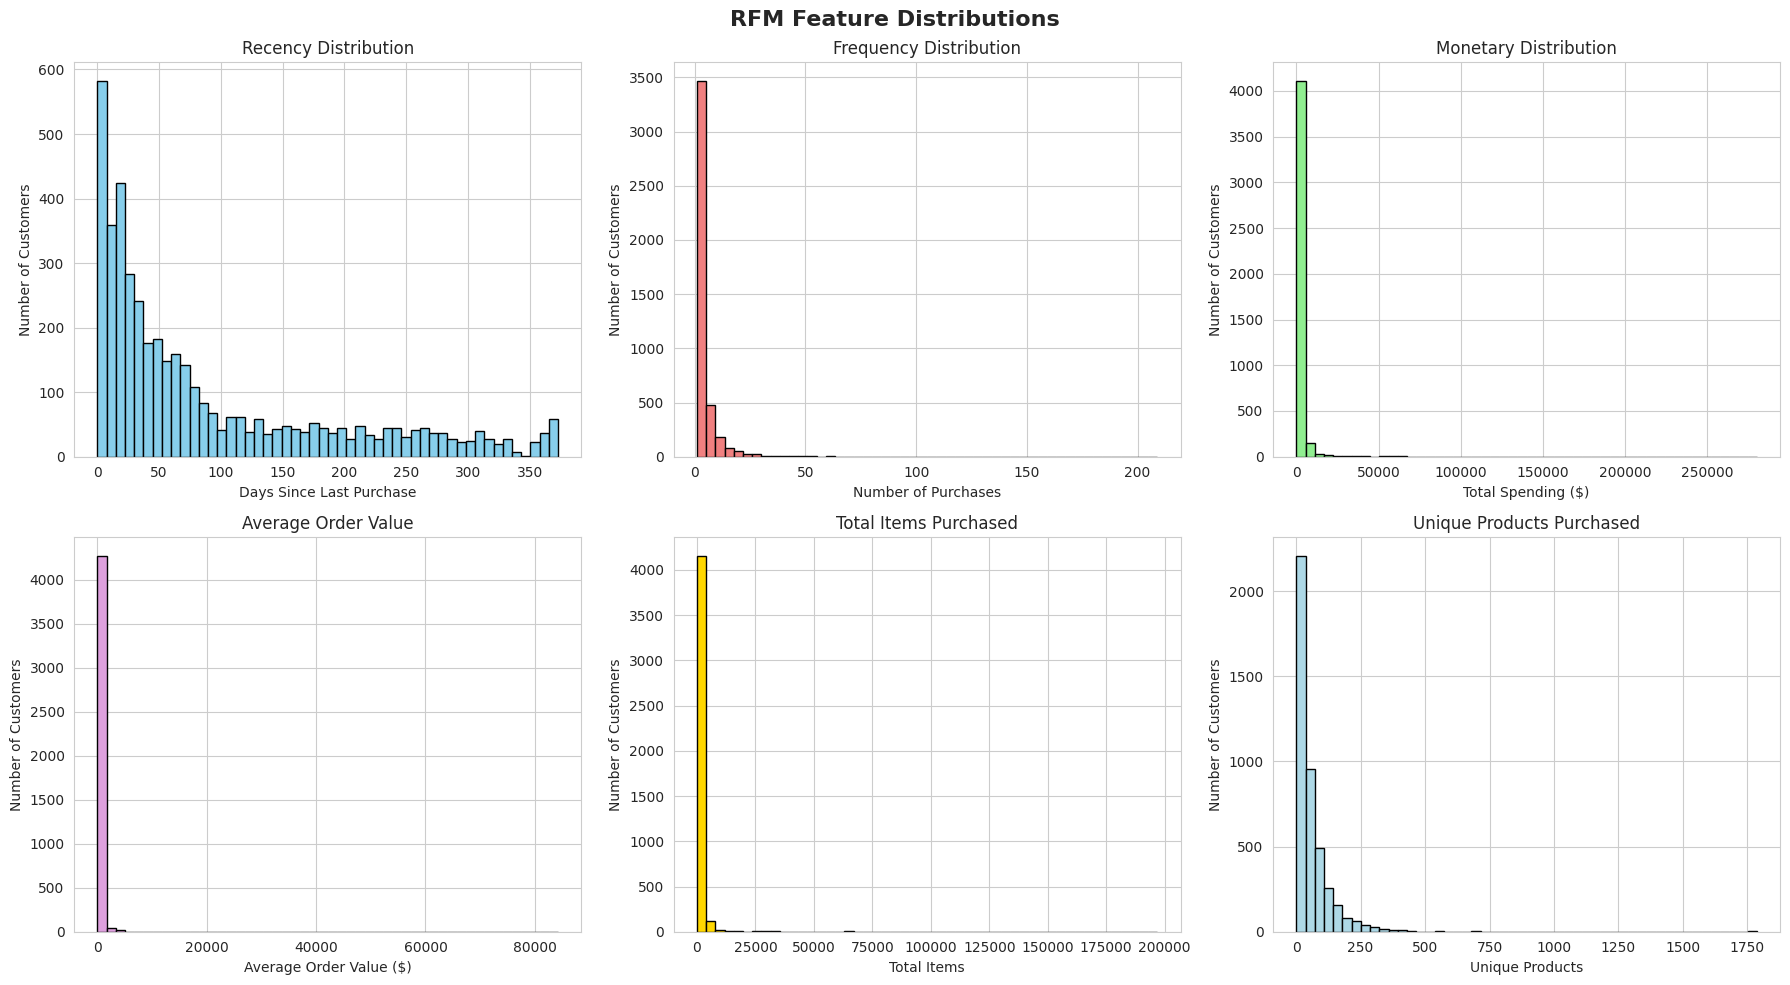

 Distribution plots created!


In [7]:
print("="*50)
print("DATA VISUALIZATION")
print("="*50)

# Create subplots for RFM distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('RFM Feature Distributions', fontsize=16, fontweight='bold')

# Recency distribution
axes[0, 0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Recency Distribution')
axes[0, 0].set_xlabel('Days Since Last Purchase')
axes[0, 0].set_ylabel('Number of Customers')

# Frequency distribution
axes[0, 1].hist(rfm['Frequency'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_xlabel('Number of Purchases')
axes[0, 1].set_ylabel('Number of Customers')

# Monetary distribution
axes[0, 2].hist(rfm['Monetary'], bins=50, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Monetary Distribution')
axes[0, 2].set_xlabel('Total Spending ($)')
axes[0, 2].set_ylabel('Number of Customers')

# Average Order Value
axes[1, 0].hist(rfm['AvgOrderValue'], bins=50, color='plum', edgecolor='black')
axes[1, 0].set_title('Average Order Value')
axes[1, 0].set_xlabel('Average Order Value ($)')
axes[1, 0].set_ylabel('Number of Customers')

# Total Items
axes[1, 1].hist(rfm['TotalItems'], bins=50, color='gold', edgecolor='black')
axes[1, 1].set_title('Total Items Purchased')
axes[1, 1].set_xlabel('Total Items')
axes[1, 1].set_ylabel('Number of Customers')

# Unique Products
axes[1, 2].hist(rfm['UniqueProducts'], bins=50, color='lightblue', edgecolor='black')
axes[1, 2].set_title('Unique Products Purchased')
axes[1, 2].set_xlabel('Unique Products')
axes[1, 2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

print(" Distribution plots created!")


In [8]:
print("="*50)
print("OUTLIER DETECTION AND TREATMENT")
print("="*50)

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Check outliers for each feature
features = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TotalItems', 'UniqueProducts']

print("Outlier Analysis:")
for feature in features:
    n_outliers, lower, upper = detect_outliers_iqr(rfm, feature)
    print(f"{feature}: {n_outliers} outliers ({n_outliers/len(rfm)*100:.2f}%)")
    print(f"  Valid range: {lower:.2f} to {upper:.2f}")

# Remove extreme outliers (using 99th percentile)
print("\n Handling outliers using 99th percentile capping...")

rfm_processed = rfm.copy()

for col in ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TotalItems', 'UniqueProducts']:
    percentile_99 = rfm_processed[col].quantile(0.99)
    rfm_processed[col] = rfm_processed[col].apply(lambda x: percentile_99 if x > percentile_99 else x)

print(" Outliers handled!")
print(f"Dataset size: {len(rfm_processed):,} customers")


OUTLIER DETECTION AND TREATMENT
Outlier Analysis:
Recency: 155 outliers (3.57%)
  Valid range: -169.00 to 327.00
Frequency: 285 outliers (6.57%)
  Valid range: -5.00 to 11.00
Monetary: 427 outliers (9.84%)
  Valid range: -1724.07 to 3693.23
AvgOrderValue: 290 outliers (6.69%)
  Valid range: -198.61 to 807.35
TotalItems: 400 outliers (9.22%)
  Valid range: -1089.12 to 2241.88
UniqueProducts: 309 outliers (7.12%)
  Valid range: -75.50 to 168.50

 Handling outliers using 99th percentile capping...
 Outliers handled!
Dataset size: 4,338 customers


In [9]:
print("="*50)
print("FEATURE SCALING")
print("="*50)

# Select features for clustering
feature_cols = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TotalItems', 'UniqueProducts']
X = rfm_processed[feature_cols]

print(f"Features selected for clustering: {feature_cols}")
print(f"\nOriginal data statistics:")
print(X.describe())

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

print("\n Features scaled successfully!")
print(f"\nScaled data statistics:")
print(X_scaled_df.describe())

FEATURE SCALING
Features selected for clustering: ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'TotalItems', 'UniqueProducts']

Original data statistics:
           Recency    Frequency      Monetary  AvgOrderValue    TotalItems  \
count  4338.000000  4338.000000   4338.000000    4338.000000   4338.000000   
mean     91.500692     4.008760   1598.576105     365.578549    925.905606   
std      99.914624     4.863497   2797.829264     313.616872   1587.999343   
min       0.000000     1.000000      3.750000       3.450000      1.000000   
25%      17.000000     1.000000    307.415000     178.625000    160.000000   
50%      50.000000     2.000000    674.485000     293.900000    379.000000   
75%     141.000000     5.000000   1661.740000     430.113750    992.750000   
max     368.000000    30.000000  19880.995700    2031.161200  11046.580000   

       UniqueProducts  
count     4338.000000  
mean        59.348087  
std         66.686269  
min          1.000000  
25%         16

FINDING OPTIMAL NUMBER OF CLUSTERS
 Testing different numbers of clusters...
K=2: Inertia=16644.61, Silhouette=0.590
K=3: Inertia=12998.83, Silhouette=0.350
K=4: Inertia=10031.92, Silhouette=0.375
K=5: Inertia=8300.64, Silhouette=0.395
K=6: Inertia=7192.22, Silhouette=0.365
K=7: Inertia=6634.42, Silhouette=0.350
K=8: Inertia=6121.94, Silhouette=0.356
K=9: Inertia=5734.06, Silhouette=0.339
K=10: Inertia=5380.03, Silhouette=0.293


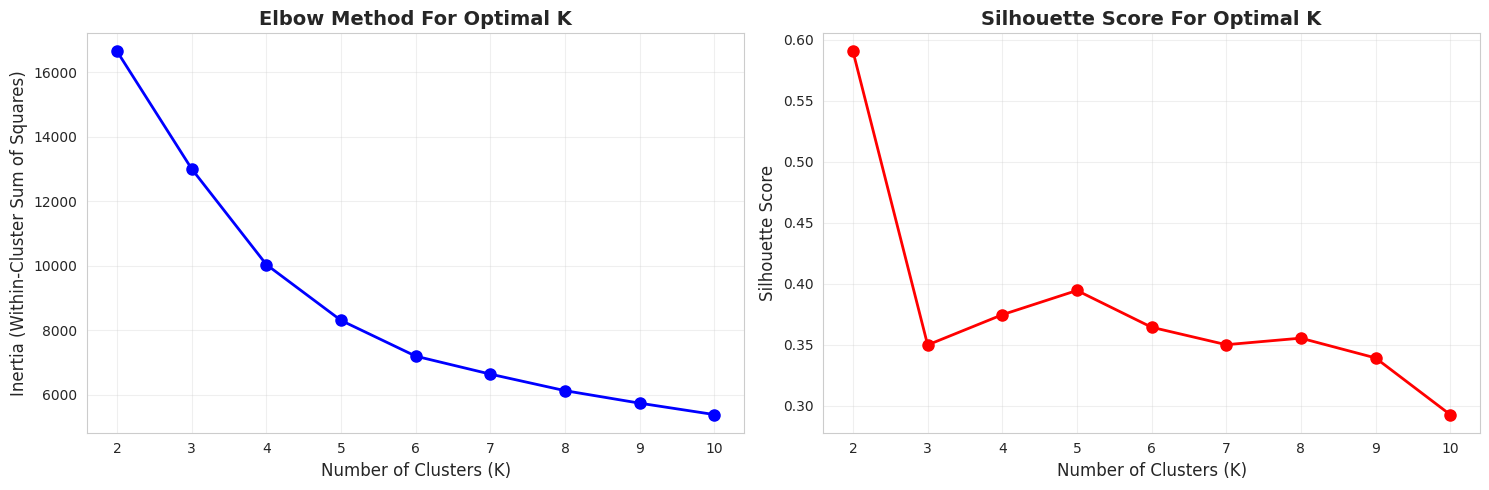


 Recommended K based on Silhouette Score: 2


In [10]:
print("="*50)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*50)

# Method 1: Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print(" Testing different numbers of clusters...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plot Elbow Method and Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow plot
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method For Optimal K', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score For Optimal K', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal K
optimal_k_silhouette = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n Recommended K based on Silhouette Score: {optimal_k_silhouette}")


In [11]:
print("="*50)
print("APPLYING K-MEANS CLUSTERING")
print("="*50)

# Use optimal K (you can change this based on the plots)
optimal_k = 4  # Change this if your analysis suggests different K
print(f"Selected K: {optimal_k}")

# Fit K-Means
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
rfm_processed['Cluster'] = clusters

print(f"\n Clustering completed!")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, clusters):.3f}")

# Cluster distribution
print("\n Cluster Distribution:")
cluster_counts = rfm_processed['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count:,} customers ({count/len(rfm_processed)*100:.1f}%)")



APPLYING K-MEANS CLUSTERING
Selected K: 4

 Clustering completed!
Silhouette Score: 0.375
Davies-Bouldin Score: 1.031

 Cluster Distribution:
Cluster 0: 2,451 customers (56.5%)
Cluster 1: 120 customers (2.8%)
Cluster 2: 1,022 customers (23.6%)
Cluster 3: 745 customers (17.2%)


CLUSTER PROFILING
Average characteristics of each cluster:
         Recency  Frequency  Monetary  AvgOrderValue  TotalItems  \
Cluster                                                            
0          47.59       2.76    805.80         312.10      484.71   
1          17.73      20.39  15067.16        1030.77     8151.82   
2         250.10       1.48    405.13         285.83      217.75   
3          30.28       8.95   3674.52         543.78     2184.97   

         UniqueProducts  
Cluster                  
0                 41.57  
1                172.07  
2                 22.81  
3                149.80  


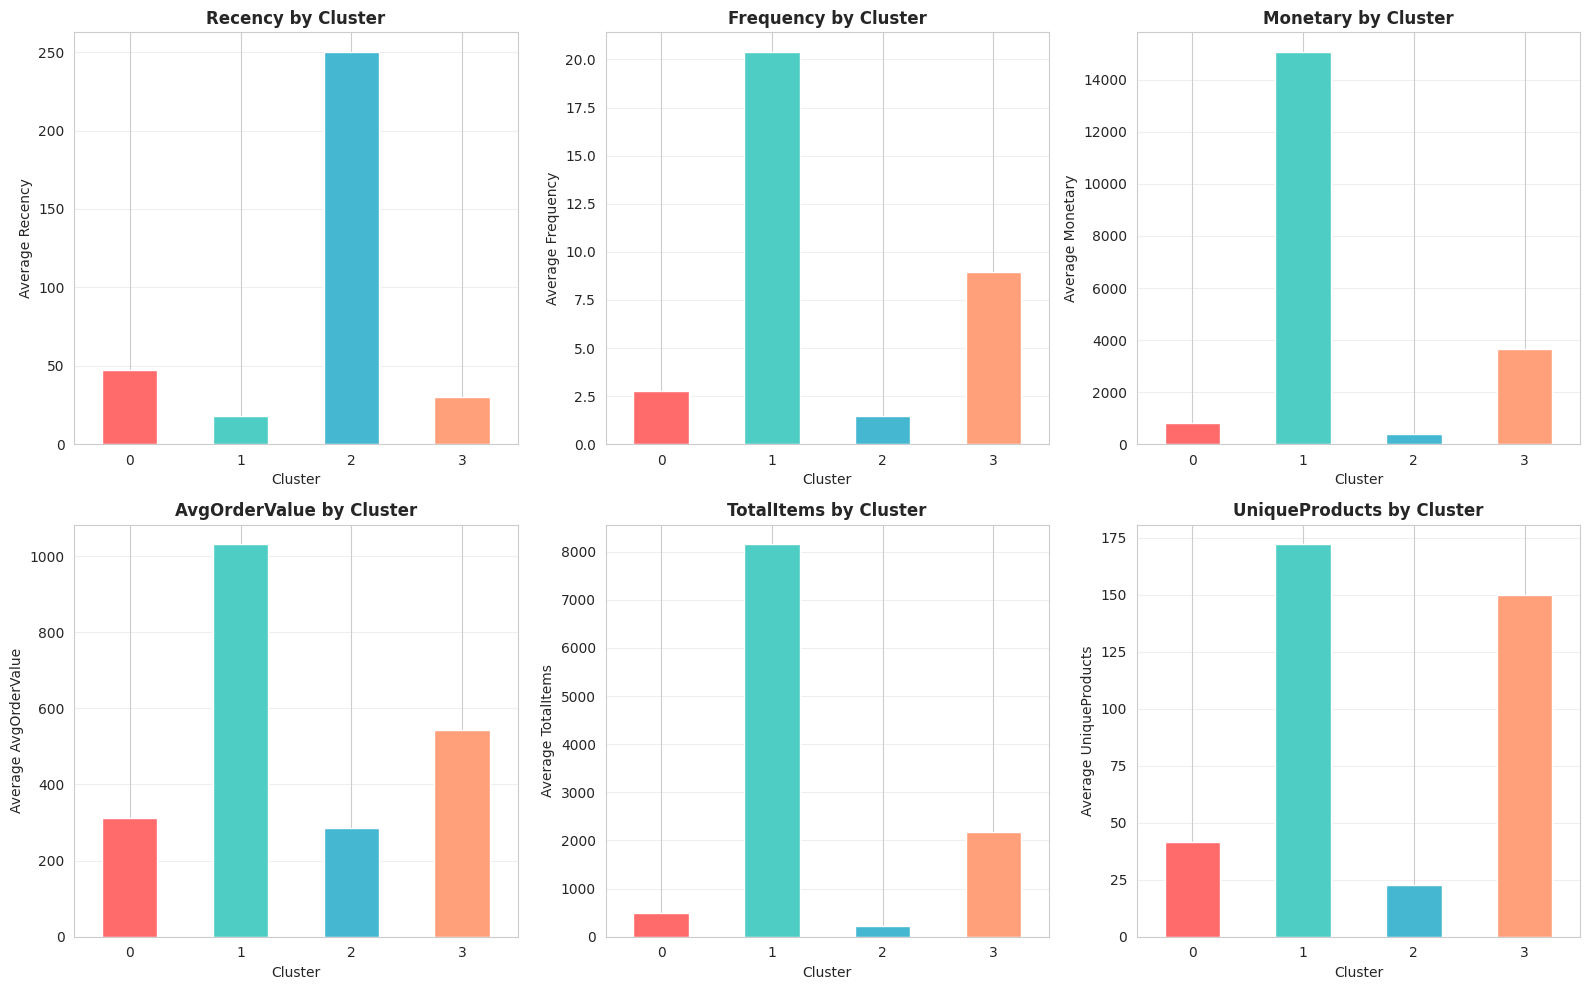


 Cluster labels assigned!


In [12]:
print("="*50)
print("CLUSTER PROFILING")
print("="*50)

# Calculate mean values for each cluster
cluster_profile = rfm_processed.groupby('Cluster')[feature_cols].mean()

print("Average characteristics of each cluster:")
print(cluster_profile.round(2))

# Visualize cluster profiles
fig = plt.figure(figsize=(16, 10))

for i, col in enumerate(feature_cols, 1):
    plt.subplot(2, 3, i)
    cluster_profile[col].plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'][:optimal_k])
    plt.title(f'{col} by Cluster', fontsize=12, fontweight='bold')
    plt.xlabel('Cluster')
    plt.ylabel(f'Average {col}')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Create cluster labels based on characteristics
def label_cluster(row):
    cluster_labels = {
        0: 'At Risk',
        1: 'Champions',
        2: 'Potential Loyalists',
        3: 'New Customers'
    }
    return cluster_labels.get(row['Cluster'], f'Cluster {row["Cluster"]}')

# You can customize these labels based on your actual cluster profiles
rfm_processed['Cluster_Name'] = rfm_processed.apply(label_cluster, axis=1)

print("\n Cluster labels assigned!")



PCA VISUALIZATION
Explained variance by PC1: 58.01%
Explained variance by PC2: 17.49%
Total explained variance: 75.50%


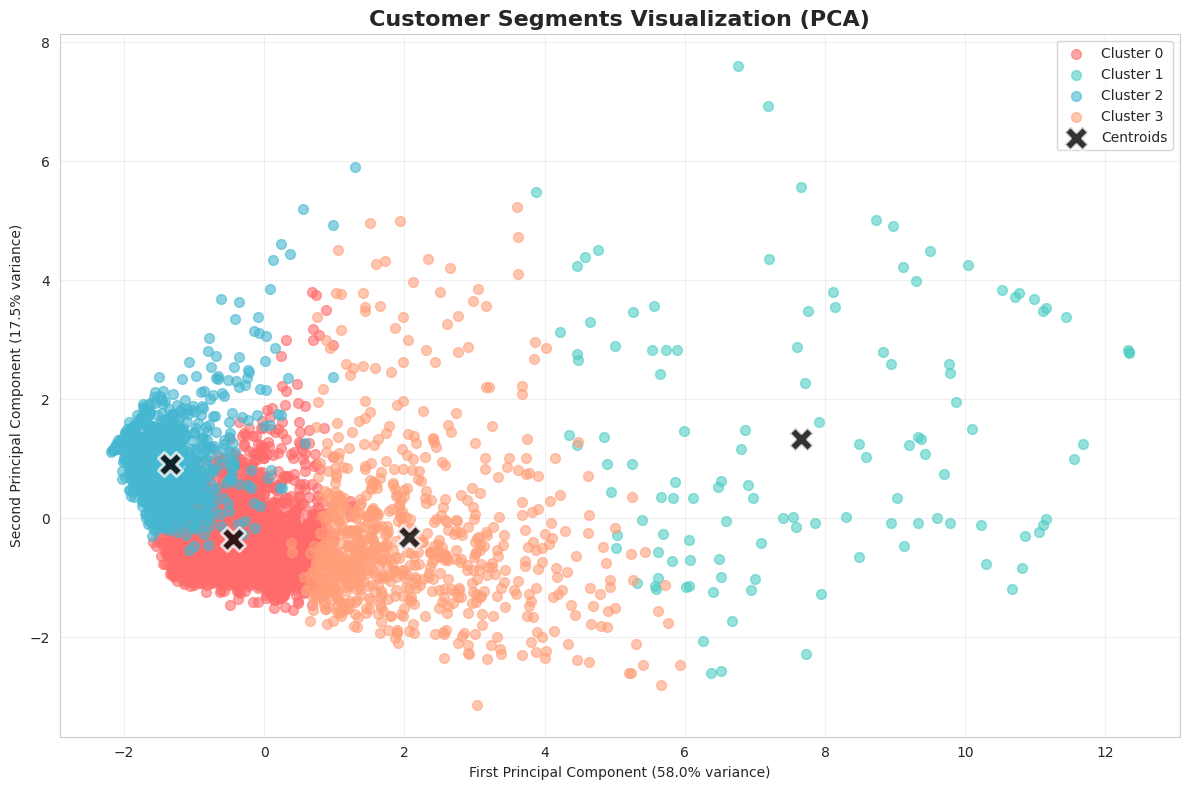

 PCA visualization created!


In [13]:
print("="*50)
print("PCA VISUALIZATION")
print("="*50)

# Apply PCA for 2D visualization
pca_2d = PCA(n_components=2, random_state=42)
principal_components_2d = pca_2d.fit_transform(X_scaled)

# Create dataframe with PCA components
pca_df = pd.DataFrame(
    data=principal_components_2d,
    columns=['PC1', 'PC2']
)
pca_df['Cluster'] = clusters
pca_df['Cluster_Name'] = rfm_processed['Cluster_Name'].values

# Explained variance
print(f"Explained variance by PC1: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")
print(f"Total explained variance: {pca_2d.explained_variance_ratio_.sum():.2%}")

# Visualize clusters in 2D
plt.figure(figsize=(12, 8))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        c=colors[cluster],
        label=f'Cluster {cluster}',
        alpha=0.6,
        s=50
    )

# Plot cluster centers
centers_pca = pca_2d.transform(kmeans_final.cluster_centers_)
plt.scatter(
    centers_pca[:, 0],
    centers_pca[:, 1],
    c='black',
    s=300,
    alpha=0.8,
    marker='X',
    edgecolors='white',
    linewidths=2,
    label='Centroids'
)

plt.xlabel(f'First Principal Component ({pca_2d.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca_2d.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Customer Segments Visualization (PCA)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" PCA visualization created!")


In [14]:
print("="*50)
print("3D INTERACTIVE VISUALIZATION")
print("="*50)

# Apply PCA for 3D
pca_3d = PCA(n_components=3, random_state=42)
principal_components_3d = pca_3d.fit_transform(X_scaled)

# Create 3D dataframe
pca_3d_df = pd.DataFrame(
    data=principal_components_3d,
    columns=['PC1', 'PC2', 'PC3']
)
pca_3d_df['Cluster'] = clusters
pca_3d_df['Cluster_Name'] = rfm_processed['Cluster_Name'].values
pca_3d_df['CustomerID'] = rfm_processed['CustomerID'].values
pca_3d_df['Monetary'] = rfm_processed['Monetary'].values

# Create interactive 3D plot
fig = px.scatter_3d(
    pca_3d_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_Name',
    hover_data=['CustomerID', 'Monetary'],
    title='Customer Segments in 3D Space',
    labels={'PC1': f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})',
            'PC2': f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})',
            'PC3': f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})'},
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(height=700)
fig.show()

print(" 3D interactive plot created!")
print(f"Total variance explained: {pca_3d.explained_variance_ratio_.sum():.2%}")


3D INTERACTIVE VISUALIZATION


 3D interactive plot created!
Total variance explained: 87.87%


In [15]:
print("="*50)
print("BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("="*50)

# Detailed cluster analysis
for cluster in range(optimal_k):
    cluster_data = rfm_processed[rfm_processed['Cluster'] == cluster]
    cluster_name = cluster_data['Cluster_Name'].iloc[0]

    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster}: {cluster_name}")
    print(f"{'='*60}")
    print(f"Customer Count: {len(cluster_data):,} ({len(cluster_data)/len(rfm_processed)*100:.1f}%)")
    print(f"\nCharacteristics:")
    print(f"  • Average Recency: {cluster_data['Recency'].mean():.1f} days")
    print(f"  • Average Frequency: {cluster_data['Frequency'].mean():.1f} purchases")
    print(f"  • Average Monetary: ${cluster_data['Monetary'].mean():.2f}")
    print(f"  • Average Order Value: ${cluster_data['AvgOrderValue'].mean():.2f}")
    print(f"  • Average Items Purchased: {cluster_data['TotalItems'].mean():.0f}")
    print(f"  • Average Unique Products: {cluster_data['UniqueProducts'].mean():.0f}")

    # Recommendations based on cluster characteristics
    print(f"\n Recommended Actions:")

    recency_avg = cluster_data['Recency'].mean()
    frequency_avg = cluster_data['Frequency'].mean()
    monetary_avg = cluster_data['Monetary'].mean()

    if recency_avg < 50 and frequency_avg > 10 and monetary_avg > 1000:
        print("   CHAMPIONS - Your best customers!")
        print("    • Reward them with VIP programs")
        print("    • Ask for reviews and testimonials")
        print("    • Offer early access to new products")
    elif recency_avg > 150 and frequency_avg < 5:
        print("   AT RISK - Need immediate attention!")
        print("    • Send win-back campaigns")
        print("    • Offer special discounts")
        print("    • Survey for feedback on why they left")
    elif frequency_avg < 5 and monetary_avg < 500:
        print("   NEW CUSTOMERS - Build relationships")
        print("    • Welcome email series")
        print("    • First purchase discounts")
        print("    • Educational content about products")
    else:
        print("   POTENTIAL LOYALISTS - Nurture them")
        print("    • Loyalty program enrollment")
        print("    • Cross-sell relevant products")
        print("    • Personalized recommendations")


BUSINESS INSIGHTS AND RECOMMENDATIONS

CLUSTER 0: At Risk
Customer Count: 2,451 (56.5%)

Characteristics:
  • Average Recency: 47.6 days
  • Average Frequency: 2.8 purchases
  • Average Monetary: $805.80
  • Average Order Value: $312.10
  • Average Items Purchased: 485
  • Average Unique Products: 42

 Recommended Actions:
   POTENTIAL LOYALISTS - Nurture them
    • Loyalty program enrollment
    • Cross-sell relevant products
    • Personalized recommendations

CLUSTER 1: Champions
Customer Count: 120 (2.8%)

Characteristics:
  • Average Recency: 17.7 days
  • Average Frequency: 20.4 purchases
  • Average Monetary: $15067.16
  • Average Order Value: $1030.77
  • Average Items Purchased: 8152
  • Average Unique Products: 172

 Recommended Actions:
   CHAMPIONS - Your best customers!
    • Reward them with VIP programs
    • Ask for reviews and testimonials
    • Offer early access to new products

CLUSTER 2: Potential Loyalists
Customer Count: 1,022 (23.6%)

Characteristics:
  • Averag

In [16]:
print("\n" + "="*50)
print("SAVING RESULTS")
print("="*50)

# Save clustered data
output_file = 'customer_segments.csv'
rfm_processed.to_csv(output_file, index=False)
print(f" Customer segments saved to: {output_file}")

# Create summary report
summary = {
    'Total Customers': len(rfm_processed),
    'Number of Clusters': optimal_k,
    'Silhouette Score': silhouette_score(X_scaled, clusters),
    'Date Analyzed': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("\n Analysis Summary:")
for key, value in summary.items():
    print(f"  • {key}: {value}")

print("\n PROJECT 1 COMPLETED SUCCESSFULLY!")
print("\n Next Steps:")
print("  1. Download this notebook: File → Download → Download .ipynb")
print("  2. Download customer_segments.csv from Colab files")
print("  3. Review the visualizations and insights")
print("  4. Prepare your report based on these findings")

# Display final results
print("\n Final Clustered Data (First 10 rows):")
rfm_processed.head(10)



SAVING RESULTS
 Customer segments saved to: customer_segments.csv

 Analysis Summary:
  • Total Customers: 4338
  • Number of Clusters: 4
  • Silhouette Score: 0.37475948518761965
  • Date Analyzed: 2025-11-21 14:36:19

 PROJECT 1 COMPLETED SUCCESSFULLY!

 Next Steps:
  1. Download this notebook: File → Download → Download .ipynb
  2. Download customer_segments.csv from Colab files
  3. Review the visualizations and insights
  4. Prepare your report based on these findings

 Final Clustered Data (First 10 rows):


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,TotalItems,UniqueProducts,Cluster,Cluster_Name
0,12346,325.0,1.0,19880.9957,2031.161200,11046.58,1.0,1,Champions
1,12347,1.0,7.0,4310.0000,615.714286,2458.00,103.0,3,New Customers
2,12348,74.0,4.0,1797.2400,449.310000,2341.00,22.0,0,At Risk
3,12349,18.0,1.0,1757.5500,1757.550000,631.00,73.0,3,New Customers
4,12350,309.0,1.0,334.4000,334.400000,197.00,17.0,2,Potential Loyalists
5,12352,35.0,8.0,2506.0400,313.255000,536.00,59.0,0,At Risk
6,12353,203.0,1.0,89.0000,89.000000,20.00,4.0,2,Potential Loyalists
7,12354,231.0,1.0,1079.4000,1079.400000,530.00,58.0,2,Potential Loyalists
8,12355,213.0,1.0,459.4000,459.400000,240.00,13.0,2,Potential Loyalists
9,12356,22.0,3.0,2811.4300,937.143333,1591.00,53.0,0,At Risk
